# Fusang analysis

## 1. Simulation data

In [1]:
# Download the data
!(cd data; cat multiz470way-urls.txt | while read url; do wget -N $url; done)

--2025-01-19 18:53:20--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/multiz470way/hg38.470way.commonNames.nh
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘hg38.470way.commonNames.nh’ not modified on server. Omitting download.

--2025-01-19 18:53:21--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/multiz100way/hg38.100way.commonNames.nh
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘hg38.100way.commonNames.nh’ not modified on server. Omitting download.

--2025-01-19 18:53:22--  https://hgdownload.soe.ucsc.edu/goldenPath/dm6/multiz124way/dm6.124way.scientificName.nh
Resolving hgdownload.soe.ucsc.edu 

In [2]:
import re

def extract_numbers_in_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        numbers = re.findall(r':(\d+\.\d+)', content)
        return [float(num) for num in numbers]

In [3]:
phylogeny_files = {
    'Mammalian': 'data/hg38.470way.commonNames.nh',
    'Vertebrate': 'data/hg38.100way.commonNames.nh',
    'Drosophila': 'data/dm6.124way.scientificName.nh',
    'Nematode': 'data/ce11.135way.scientificName.nh',
    'Virus': 'data/eboVir3.strainNames.160way.nh',
}

branch_lengths = {}
for group, file in phylogeny_files.items():
    branch_lengths[group] = extract_numbers_in_file(file)

In [4]:
for (group, lengths) in branch_lengths.items():
    print(f"{group}: {len(lengths)} branch lengths, max: {max(lengths)}")


Mammalian: 938 branch lengths, max: 0.526739
Vertebrate: 198 branch lengths, max: 0.977944
Drosophila: 248 branch lengths, max: 2.51517
Nematode: 270 branch lengths, max: 1.22545
Virus: 318 branch lengths, max: 0.1


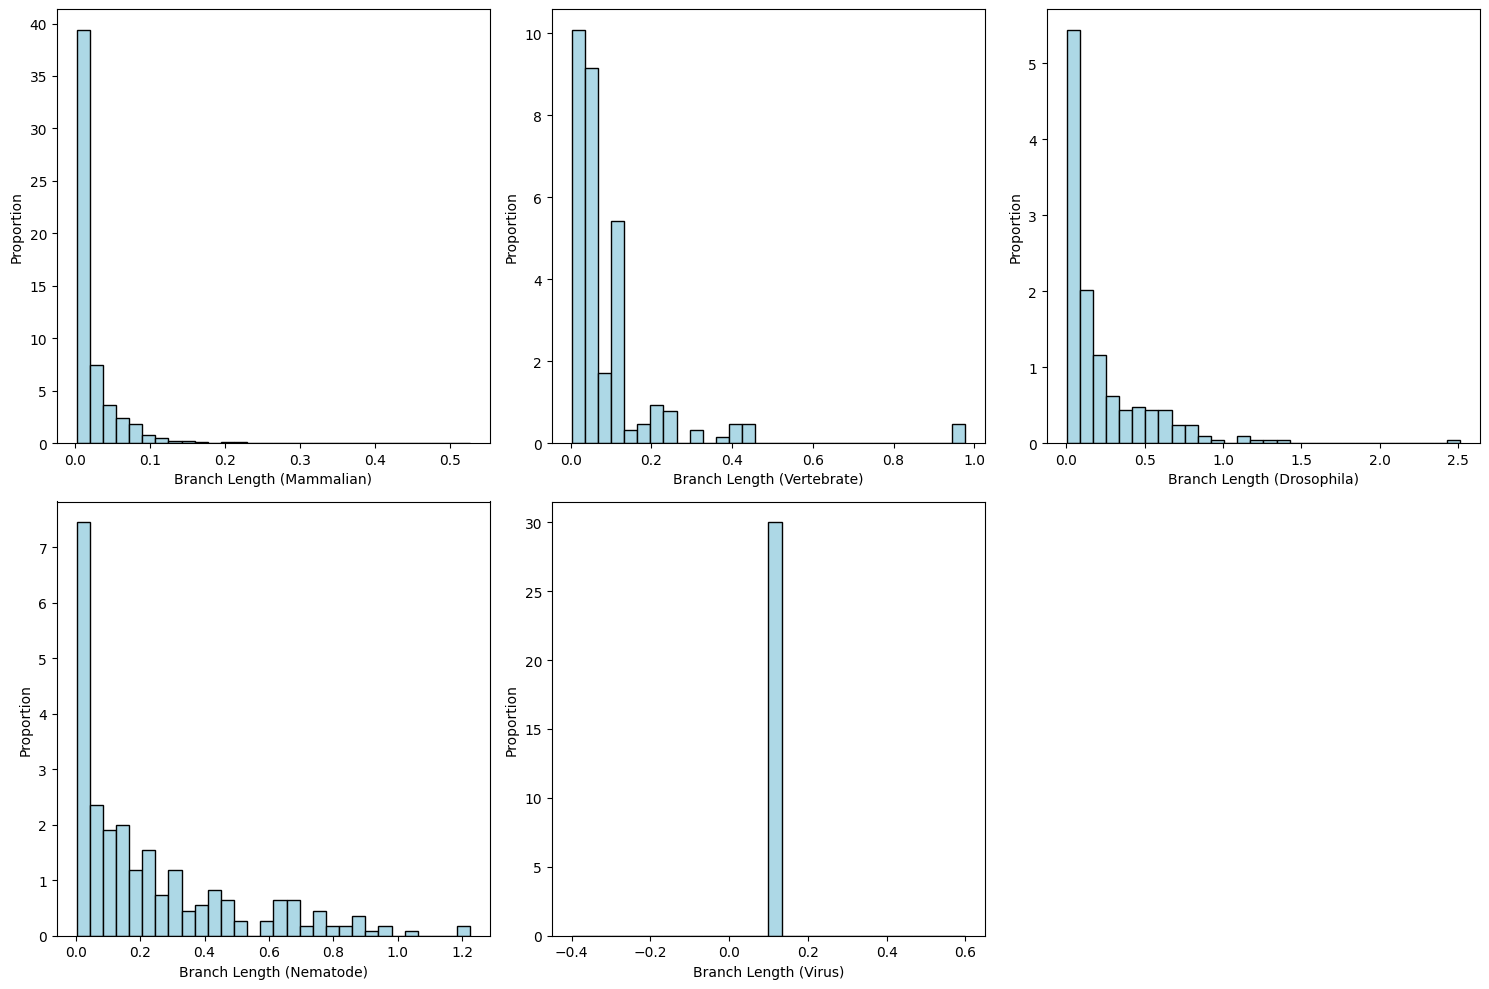

In [5]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(nrows=len(branch_lengths)//3 + (len(branch_lengths) % 3 > 0), ncols=3, figsize=(15, 5 * (len(branch_lengths)//3 + (len(branch_lengths) % 3 > 0))))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plot each group's branch lengths
for i, (group, lengths) in enumerate(branch_lengths.items()):
    axs[i].hist(lengths, bins=30, density=True, color='lightblue', edgecolor='black')
    axs[i].set_xlabel('Branch Length (' + group + ')')
    axs[i].set_ylabel('Proportion')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [35]:
import numpy as np
import pandas as pd
from scipy.spatial import distance

jsd_matrix = np.zeros((len(branch_lengths), len(branch_lengths)))
for i, group_1 in enumerate(branch_lengths.keys()):
    for j, group_2 in enumerate(branch_lengths.keys()):
        data1 = branch_lengths[group_1]
        data2 = branch_lengths[group_2]
        min_val = min(np.min(data1), np.min(data2))
        max_val = max(np.max(data1), np.max(data2))
        bins = np.linspace(min_val, max_val, 20)
        hist1, _ = np.histogram(data1, bins=bins, density=True)
        hist2, _ = np.histogram(data2, bins=bins, density=True)
        jsd = distance.jensenshannon(hist1, hist2) ** 2
        jsd_matrix[i, j] = jsd

group_names = list(branch_lengths.keys())
jsd_matrix_df = pd.DataFrame(jsd_matrix, index=group_names, columns=group_names)

print(jsd_matrix_df)


            Mammalian  Vertebrate  Drosophila  Nematode     Virus
Mammalian    0.000000    0.077825    0.166547  0.217521  0.637275
Vertebrate   0.077825    0.000000    0.091311  0.115006  0.370360
Drosophila   0.166547    0.091311    0.000000  0.017501  0.196252
Nematode     0.217521    0.115006    0.017501  0.000000  0.487895
Virus        0.637275    0.370360    0.196252  0.487895       NaN


/work/Projects/Fusang/.venv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/work/Projects/Fusang/.venv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [37]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.spatial import distance

jsd_matrix = np.zeros((len(branch_lengths), len(branch_lengths)))
for i, group_1 in enumerate(branch_lengths.keys()):
    for j, group_2 in enumerate(branch_lengths.keys()):
        data1 = branch_lengths[group_1]
        data2 = branch_lengths[group_2]
        min_val = min(np.min(data1), np.min(data2))
        max_val = max(np.max(data1), np.max(data2))
        kde1 = gaussian_kde(data1)
        kde2 = gaussian_kde(data2)
        bins = np.linspace(min_val, max_val, 1000)
        hist1 = kde1(bins)
        hist2 = kde2(bins)
        jsd = distance.jensenshannon(hist1, hist2) ** 2
        jsd_matrix[i, j] = jsd

group_names = list(branch_lengths.keys())
jsd_matrix_df = pd.DataFrame(jsd_matrix, index=group_names, columns=group_names)

print(jsd_matrix_df)

/work/Projects/Fusang/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1382: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/work/Projects/Fusang/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1381: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


            Mammalian  Vertebrate  Drosophila  Nematode  Virus
Mammalian    0.000000    0.193023    0.349038  0.356819    NaN
Vertebrate   0.193023    0.000000    0.109358  0.116836    NaN
Drosophila   0.349038    0.109358    0.000000  0.004229    NaN
Nematode     0.356819    0.116836    0.004229  0.000000    NaN
Virus             NaN         NaN         NaN       NaN    0.0


In [19]:
from scipy.spatial import distance

a = np.array([1, 2, 3, 4, 5])
b = np.array([2, 4, 6, 8, 10])

d = distance.jensenshannon(a, b)
print(d)

0.0


In [23]:
import numpy as np

def D(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sum(a * np.log(a / b))

print(D(a, b))
print(D(b, a))


-10.39720770839918
20.79441541679836


In [24]:
def JSD(a, b):
    a = np.array(a)
    b = np.array(b)
    c = (a + b) / 2
    return (D(a, c) + D(b, c)) / 2

print(JSD(a, b))
print(JSD(b, a))

1.2742427759654795
1.2742427759654795


In [25]:
import numpy as np
import pandas as pd

jsd_matrix = np.zeros((len(branch_lengths), len(branch_lengths)))
for i, group_1 in enumerate(branch_lengths.keys()):
    for j, group_2 in enumerate(branch_lengths.keys()):
        min_size = min(len(branch_lengths[group_1]), len(branch_lengths[group_2]))
        jsd = JSD(branch_lengths[group_1][:min_size], branch_lengths[group_2][:min_size])
        jsd_matrix[i, j] = jsd

group_names = list(branch_lengths.keys())
jsd_matrix_df = pd.DataFrame(jsd_matrix, index=group_names, columns=group_names)

print(jsd_matrix_df)


            Mammalian  Vertebrate  Drosophila   Nematode     Virus
Mammalian    0.000000    4.053391   14.757583  16.544925  5.627237
Vertebrate   4.053391    0.000000    9.729034  11.086591  2.583968
Drosophila  14.757583    9.729034    0.000000  17.354359  9.053691
Nematode    16.544925   11.086591   17.354359   0.000000  9.692790
Virus        5.627237    2.583968    9.053691   9.692790  0.000000


In [26]:
from scipy.stats import entropy

entropy(a, b)


np.float64(0.0)

In [28]:
entropy([1, 2, 3, 4, 5])

np.float64(1.4897503188505912)

In [29]:
a

array([1, 2, 3, 4, 5])

In [30]:
np.sum(a * np.log(a))

np.float64(18.274498233774285)

In [31]:
np.histogram(a, bins=30, density=True)

(array([1.5, 0. , 0. , 0. , 0. , 0. , 0. , 1.5, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 1.5, 0. , 0. , 0. , 0. , 0. , 0. , 1.5, 0. , 0. , 0. ,
        0. , 0. , 0. , 1.5]),
 array([1.        , 1.13333333, 1.26666667, 1.4       , 1.53333333,
        1.66666667, 1.8       , 1.93333333, 2.06666667, 2.2       ,
        2.33333333, 2.46666667, 2.6       , 2.73333333, 2.86666667,
        3.        , 3.13333333, 3.26666667, 3.4       , 3.53333333,
        3.66666667, 3.8       , 3.93333333, 4.06666667, 4.2       ,
        4.33333333, 4.46666667, 4.6       , 4.73333333, 4.86666667,
        5.        ]))

In [32]:
np.histogram(b, bins=30, density=True)

(array([0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.75]),
 array([ 2.        ,  2.26666667,  2.53333333,  2.8       ,  3.06666667,
         3.33333333,  3.6       ,  3.86666667,  4.13333333,  4.4       ,
         4.66666667,  4.93333333,  5.2       ,  5.46666667,  5.73333333,
         6.        ,  6.26666667,  6.53333333,  6.8       ,  7.06666667,
         7.33333333,  7.6       ,  7.86666667,  8.13333333,  8.4       ,
         8.66666667,  8.93333333,  9.2       ,  9.46666667,  9.73333333,
        10.        ]))